In [2]:
from __future__ import division
import os
import numpy as np
import time
import matplotlib.pyplot as plt
import scipy as scp
import pylab as pyl



import warnings
warnings.filterwarnings('ignore')
np.random.seed(1234)

%matplotlib inline 

%load_ext autoreload                                                                                                                                                                                                
%autoreload 

In [3]:
%load_ext autoreload
%autoreload 2
    

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
if not os.path.isdir('Spectralplot_images'):
    os.makedirs('Spectralplot_images')


In [5]:
"""To compute distance matrix"""
def distmat(x,y):
    return np.sum( x**2,0 )[:,None] + np.sum( y**2,0 )[None,:] - 2*x.transpose().dot(y)

"""To Normalise a vector"""
normalize = lambda a: a/np.sum( a )

"""To Compute P"""
def GetP(u,K,v):
    return u[:,None]*K*v[None,:]

def plotp(x, col,plt, scale=200, edgecolors="k"):
  return plt.scatter( x[0,:], x[1,:], s=scale, edgecolors=edgecolors,  c=col, cmap='plasma', linewidths=2 )

In [6]:
def generate_data(N):
    """
     N is a list of the size of the data on x and y
    """
    x = np.random.rand( 2,N[0] )-0.5
    theta = 2*np.pi*np.random.rand( 1,N[1] )
    r = 0.8+.2*np.random.rand( 1,N[1] )
    y = np.vstack( ( r*np.cos( theta ),r*np.sin( theta ) ) )
    return x,y

In [7]:
def spectral_decomposition(mat):
    eig, v = np.linalg.eigh( mat )
    sorting_indices = np.argsort(eig)
    eig = eig[sorting_indices]
    v   = v[:, sorting_indices]
    
    print( "List of smallest eigenvalues: ", eig[:10])
    print( "List of largest  eigenvalues: ", eig[-10:])

    return eig,v



In [8]:
def precondition_matrix(matrix, precond_vectors,null_vector):
    diag   = 1/np.sqrt(np.diag( matrix ).flatten())
    matrix = diag[:,None]*matrix*diag[None,:]

    vector = null_vector
    vector = vector/diag
    vector = vector/np.linalg.norm( vector )
    vector = vector.reshape( (len( vector ), 1) )
    matrix = matrix + np.dot( vector, vector.T )
    k = len( precond_vectors )
    n = null_vector.shape[0]
    y = np.array( precond_vectors ).T # Matrix of size n by k
    # Compute eigenvalues
    Ay = np.dot( matrix, y )
    eigenvalues = np.sum( y * Ay, axis=0 )
    # Compute P_matrix = id + y*diag(values)*y.T
    values = ( 1/np.sqrt(eigenvalues)-1 )    # Vector of size k
    z = y*values[None,:]
    P_matrix = np.identity( n ) + np.dot( z, y.T )
    B = np.dot( Ay, z.T )
    C = z @ np.dot( y.T, Ay ) @ z.T
    matrix = matrix + B + B.T + C
    return matrix



In [9]:
import computational_OT

In [10]:
N = [ 500,600 ]
x,y = generate_data(N)

### Log-domain Sinkhorn 

In [11]:
a = normalize(np.ones(N[0]))
b = normalize(np.ones(N[1]))
# Log domain Sinkhorn
print("Log domain Sinkhorn.... ")
results_logSinkhorn = []
times_logSinkhorn   = []
logsinkhornP        = []
epsilons = [ 1.0, 0.5, 0.1 , 0.05 , 0.01,  0.001, 0.00086]
# epsilons = [1.0]

# epsilons = [1.0, 0.5, 0.3, 0.1, 0.09, 0.05, 0.03, 0.02, 0.001]
# epsilons = [1.0]
#Cost matrix
C = distmat(x,y)
for eps in epsilons:

  print( "Sinkhorn for epsilon = "+str(eps)+":" )    
  



  print( "Doing for (",N[0],N[1],")." )
  print( " |- Iterating" )

  start = time.time()
  logsinkhorn = computational_OT.Log_domainSinkhorn(a,b,C,eps)
  output = logsinkhorn.update( niter = 500 )
  results_logSinkhorn.append( output )
  end = time.time()
  times_logSinkhorn.append(1e-3*(end-start) )
  logsinkhornP.append(GetP(output['potential_f']/eps, np.exp(-C/eps),output['potential_g']/eps))

Log domain Sinkhorn.... 
Sinkhorn for epsilon = 1.0:
Doing for ( 500 600 ).
 |- Iterating
P time:  1.56400203704834e-05
P time:  1.416301727294922e-05
P time:  8.670806884765626e-06
P time:  8.776426315307617e-06
P time:  8.809566497802735e-06
P time:  1.0221958160400391e-05
P time:  9.10472869873047e-06
P time:  8.435487747192383e-06
P time:  8.455753326416016e-06
P time:  7.554531097412109e-06
P time:  1.0996103286743165e-05
P time:  8.606433868408203e-06
P time:  7.75289535522461e-06
P time:  7.803440093994142e-06
Terminating after iteration:  13
Sinkhorn for epsilon = 0.5:
Doing for ( 500 600 ).
 |- Iterating
P time:  9.072303771972656e-06
P time:  1.059579849243164e-05
P time:  9.782075881958009e-06
P time:  9.349346160888672e-06
P time:  8.107662200927734e-06
P time:  7.04193115234375e-06
P time:  8.666276931762696e-06
P time:  1.0900497436523437e-05
P time:  1.0978221893310547e-05
P time:  1.0188102722167969e-05
P time:  1.0725498199462892e-05
P time:  5.801200866699219e-06
P ti

#### Error plot

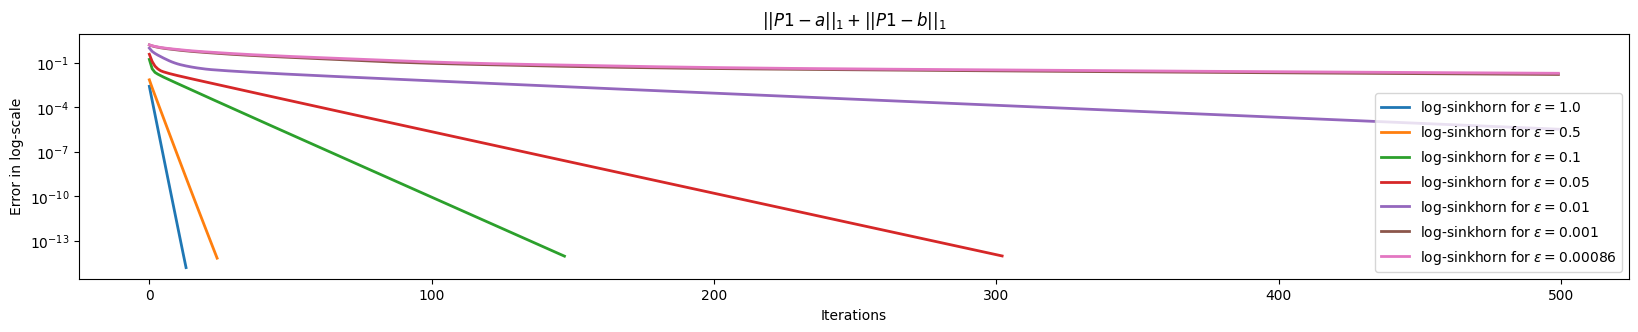

In [12]:
plt.figure( figsize = (20,7) )

plt.subplot(2,1,1),
plt.title( "$||P1 -a||_1+||P1 -b||_1$" )
for i in range( len( results_logSinkhorn) ):
  error = np.asarray( results_logSinkhorn[i]['error'])
  plt.plot( error, label = 'log-sinkhorn for $\epsilon=$'+ str(epsilons[i]) , linewidth = 2 )
plt.yscale( 'log' )
plt.legend()
plt.xlabel("Iterations")
plt.ylabel("Error in log-scale")
plt.show()


In [13]:
flogsinkhorn, glogsinkhorn = [], []
for i in range(len(results_logSinkhorn)):
    flogsinkhorn.append(results_logSinkhorn[i]['potential_f'])
    glogsinkhorn.append(results_logSinkhorn[i]['potential_g'])

#### Spectral plot

In [14]:
Hessians_logsinkhorn = []
for i in range(len(epsilons)):
    u  = np.exp((results_logSinkhorn[i]['potential_f'])/epsilons[i])  
    v  = np.exp((results_logSinkhorn[i]['potential_g'])/epsilons[i])
    K  = np.exp(-C/epsilons[i])
    r1 = u[:,None]*np.dot(K,v)[:,None] 
    r2 = v[:,None]*np.dot(K.T,u)[:,None]                                
    P  = u[:,None]*np.exp(-C/epsilons[i])*v[None,:]
    A  = np.diag( np.array(r1.reshape(r1.shape[0],)) )
    B  = P       
    C_  = P.T
    D  = np.diag( np.array(r2.reshape(r2.shape[0],)) )
    result = np.vstack( ( np.hstack((A,B)), np.hstack((C_,D)) ) )    
    Hessians_logsinkhorn.append(result)

In [15]:
eigs = []
eigvecs = []
for i in range(len(epsilons)):
    eps = epsilons[i]
    print("Spectral statistics of Hessian for epsilon="+str(eps))
    diag   = 1/np.sqrt(np.diag( Hessians_logsinkhorn[i] ).flatten())
    result = diag[:,None]*Hessians_logsinkhorn[i]*diag[None,:]
    ev = spectral_decomposition( result )
    eigs.append(ev[0])
    eigvecs.append(ev[1])
    print("")


Spectral statistics of Hessian for epsilon=1.0
List of smallest eigenvalues:  [-1.03736464e-15  6.48489571e-01  6.64969678e-01  9.15826321e-01
  9.43785390e-01  9.89048065e-01  9.89607240e-01  9.90276224e-01
  9.98504570e-01  9.98616669e-01]
List of largest  eigenvalues:  [1.00138333 1.00149543 1.00972378 1.01039276 1.01095194 1.05621461
 1.08417368 1.33503032 1.35151043 2.        ]

Spectral statistics of Hessian for epsilon=0.5
List of smallest eigenvalues:  [-4.07226336e-16  4.23862028e-01  4.45177314e-01  7.60246766e-01
  8.26259253e-01  9.41341914e-01  9.43222244e-01  9.68995164e-01
  9.87868093e-01  9.88516659e-01]
List of largest  eigenvalues:  [1.01148334 1.01213191 1.03100484 1.05677776 1.05865809 1.17374075
 1.23975323 1.55482269 1.57613797 2.        ]

Spectral statistics of Hessian for epsilon=0.1
List of smallest eigenvalues:  [-1.10488672e-15  9.25797263e-02  1.01062875e-01  2.70738661e-01
  3.23314694e-01  5.00338560e-01  5.08021851e-01  6.56911422e-01
  6.98637358e-01  

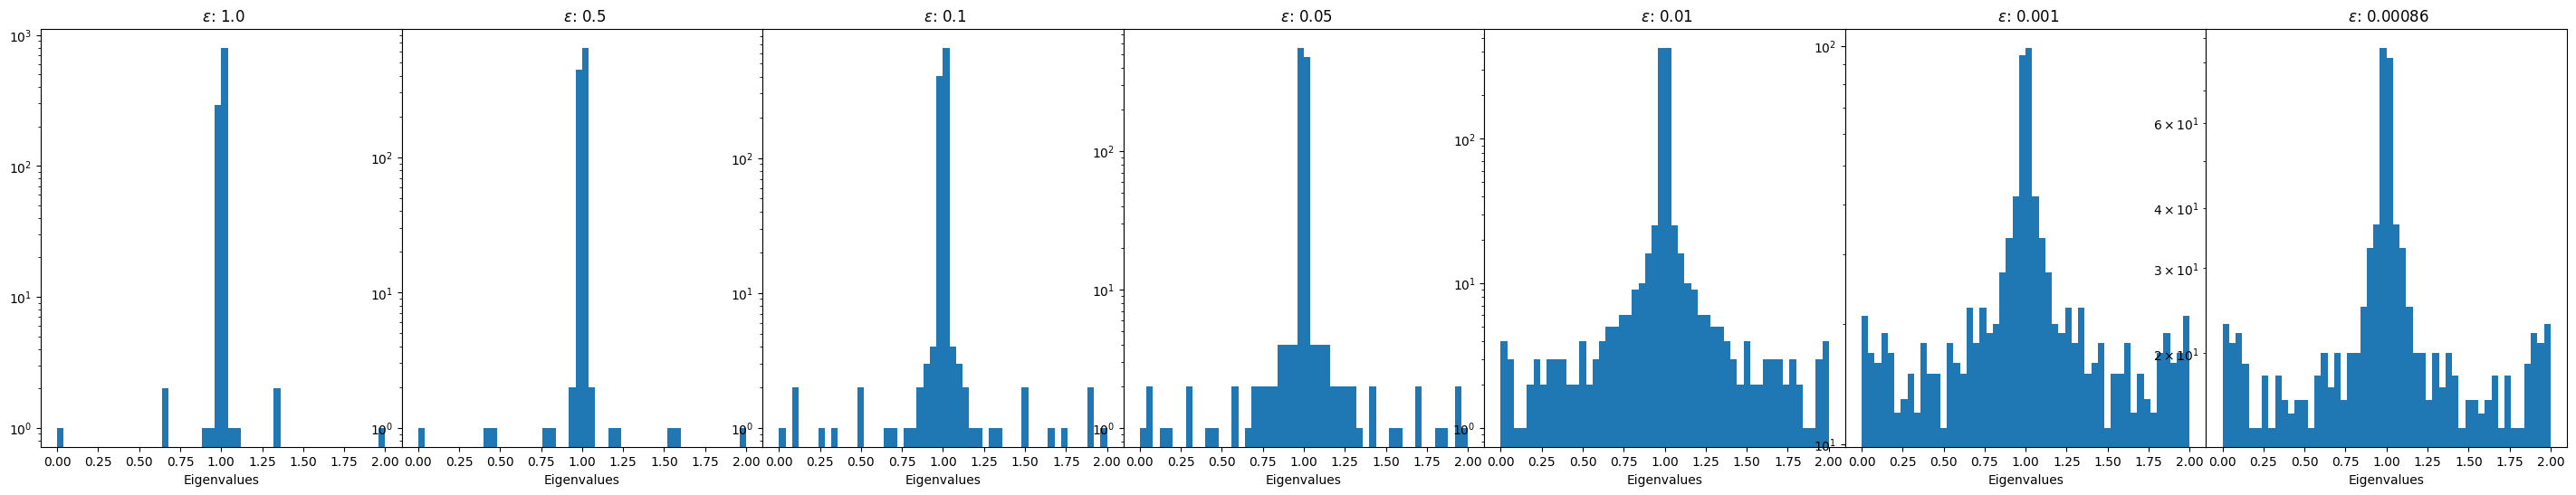

In [16]:
fig,ax = plt.subplots(figsize = (36,6),nrows = 1, ncols = len(epsilons), sharey = False)
plt.title("Histogram of eigenvalues.")
for i in range(len(epsilons)):
    ax[i].hist( eigs[i], 50)
    ax[i].set_title( " $\epsilon$: "+str(epsilons[i]))
    ax[i].set_xlabel("Eigenvalues")
    # ax[i].set_ylim(ymin = 0)
    # ax[i].set_ylim(bottom = 1e-1)
    ax[i].set_yscale( "log" )       
plt.subplots_adjust(wspace=0,hspace=0)
plt.show()

#### Spectral plots with preconditioning

In [17]:
def build_preconditioners( num_eigs,modified_Hessian, ansatz=True ):
    # Diagonalize
    eigenvalues, eigenvectors = np.linalg.eigh( modified_Hessian )
    sorting_indices = np.argsort( eigenvalues )
    eigenvalues  = eigenvalues[sorting_indices]
    eigenvectors = eigenvectors[:, sorting_indices]
    # Form null vector
    if not ansatz:
        null_vector = eigenvectors[:, 0]
    else:
        null_vector = np.hstack( (np.ones(N[0]), -np.ones(N[1])) )
        norm = np.sqrt( N[0] + N[1] )
        null_vector = null_vector/norm
    # Form other vectors (only 13)
    n,m = eigenvectors.shape
    indices=[]
    for i in range(num_eigs//2):
        indices.append(m-i-1)
        indices.append(i+1)
    if num_eigs//2!=0:
        indices.append(m-1-num_eigs//2)
   
    precond_vectors = eigenvectors[:, indices ]
    precond_vectors = []
    for index in indices:
        precond_vectors.append( eigenvectors[:,index] )
    #
    return null_vector, precond_vectors

In [18]:
# preconditioned_Hessians = []
# for i in range(len(epsilons)):
#     num_eigs = 13
#     null_vector, precond_vectors = build_preconditioners( num_eigs, Hessians_logsinkhorn[i], ansatz=False )
#     preconditioned_Hessians.append(precondition_matrix(Hessians_logsinkhorn[i], precond_vectors,null_vector))


In [19]:
preconditioned_Hessians = []
for i in  range(len(epsilons)):
    num_eigs = 13
    null_vector, precond_vectors = build_preconditioners( num_eigs, Hessians_logsinkhorn[i], ansatz=False )
    vector = null_vector
    vector = vector/diag
    vector = vector/np.linalg.norm( vector )
    vector = vector.reshape( ( len( vector ), 1) )
    preconditioned_Hessians.append(Hessians_logsinkhorn[i]+ np.dot( vector, vector.T ))

In [20]:
eigs = []
eigvecs = []
for i in range(len(epsilons)):
    eps = epsilons[i]
    print("Spectral statistics of Hessian for epsilon="+str(eps))
    ev = spectral_decomposition( preconditioned_Hessians[i])
    eigs.append(ev[0])
    eigvecs.append(ev[1])
    print("")


Spectral statistics of Hessian for epsilon=1.0
List of smallest eigenvalues:  [0.00117024 0.00119935 0.00160662 0.0016376  0.00166547 0.00166559
 0.00166572 0.00166655 0.00166664 0.00166665]
List of largest  eigenvalues:  [0.00200002 0.00200094 0.00200108 0.00200119 0.00202907 0.00206004
 0.0024673  0.00249634 0.00365905 1.0000081 ]

Spectral statistics of Hessian for epsilon=0.5
List of smallest eigenvalues:  [0.00076831 0.00080675 0.00136495 0.00147501 0.00163522 0.00163706
 0.00165731 0.0016652  0.00166535 0.00166589]
List of largest  eigenvalues:  [0.00200146 0.00200935 0.00202961 0.00203144 0.00219166 0.00230171
 0.00285991 0.00289827 0.00365905 1.0000081 ]

Spectral statistics of Hessian for epsilon=0.1
List of smallest eigenvalues:  [0.00016825 0.00018366 0.0004915  0.00058669 0.00090598 0.00091978
 0.00118515 0.00125843 0.00143146 0.00144884]
List of largest  eigenvalues:  [0.00240823 0.00248152 0.00274689 0.00276069 0.00307998 0.00317516
 0.00348298 0.00349833 0.00365905 1.000

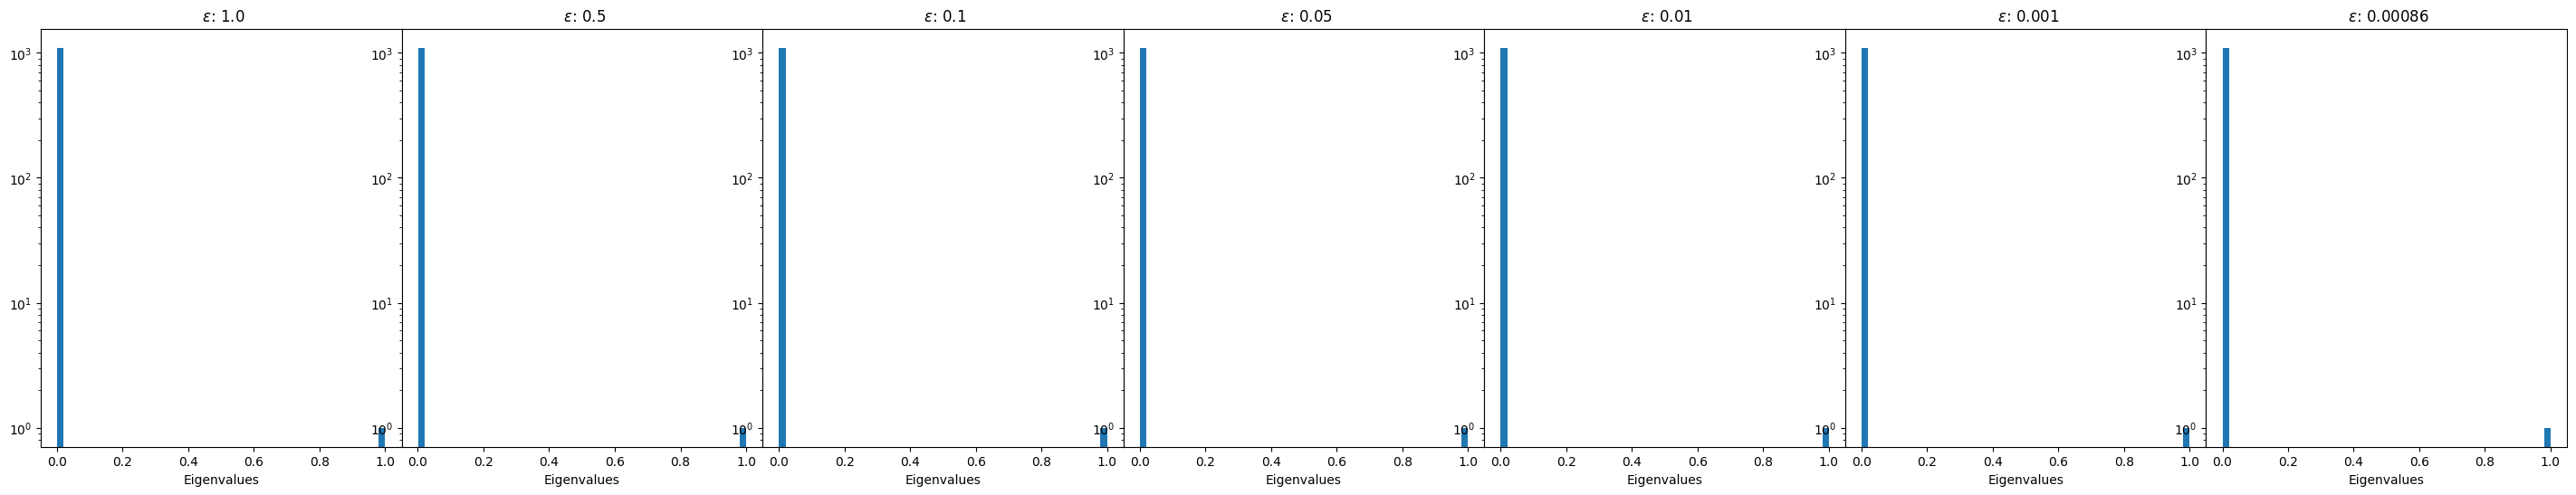

In [21]:
fig,ax = plt.subplots(figsize = (36,6),nrows = 1, ncols = len(epsilons), sharey = False)
plt.title("Histogram of eigenvalues.")
for i in range(len(epsilons)):
    ax[i].hist( eigs[i], 50)

    ax[i].set_title( " $\epsilon$: "+str(epsilons[i]))
    ax[i].set_xlabel("Eigenvalues")
    # ax[i].set_ylim(ymin = 0)
    # ax[i].set_ylim(bottom = 1e-1)
    ax[i].set_yscale( "log" )       
plt.subplots_adjust(wspace=0,hspace=0)
plt.show()

### Sinkhorn

In [ ]:
# Sinkhorn
print("Sinkhorn.... ")
SinkhornP = []
results_Sinkhorn = []
times_Sinkhorn = []
epsilons = [ 1.0, 0.5, 0.1 , 0.05 , 0.01,  0.001, 0.00086]
Pmatrix_dist_linVSsinkhorn = []
 # a and b
a = normalize(np.ones(N[0]))
a = a.reshape(a.shape[0],-1)
b = normalize(np.ones(N[1]))
b = b.reshape(b.shape[0],-1)
#Cost matrix
C = distmat(x,y)
for eps in epsilons:

  
  print("Sinkhorn for epsilon: ", eps)


  #Kernel
  K = np.exp(-C/eps)


  print("Doing for (",N[0],N[1],").")
  print( " |- Iterating")

  #Inflating
  u = a
  v = b

  start     = time.time()
  Optimizer = computational_OT.Sinkhorn(K,a,b,u,v,eps)
  out       = Optimizer._update()
  results_Sinkhorn.append(out)
  end       = time.time()
  times_Sinkhorn.append(end-start)
  print( " |- Computing P")
  print( "" )
  SinkhornP.append(GetP(out['potential_f']/eps,K,out['potential_g']/eps))
  

Sinkhorn.... 
Sinkhorn for epsilon:  1.0
Doing for ( 500 600 ).
 |- Iterating
Terminating after iteration:  10
 |- Computing P

Sinkhorn for epsilon:  0.5
Doing for ( 500 600 ).
 |- Iterating
Terminating after iteration:  19
 |- Computing P

Sinkhorn for epsilon:  0.1
Doing for ( 500 600 ).
 |- Iterating
Terminating after iteration:  109
 |- Computing P

Sinkhorn for epsilon:  0.05
Doing for ( 500 600 ).
 |- Iterating
Terminating after iteration:  224
 |- Computing P

Sinkhorn for epsilon:  0.01
Doing for ( 500 600 ).
 |- Iterating
Terminating after iteration:  1000
 |- Computing P

Sinkhorn for epsilon:  0.001
Doing for ( 500 600 ).
 |- Iterating
Terminating after iteration:  1000
 |- Computing P

Sinkhorn for epsilon:  0.00086
Doing for ( 500 600 ).
 |- Iterating
Terminating after iteration:  1
 |- Computing P



In [ ]:
fsinkhorn, gsinkhorn = [], []
for i in range(len(results_Sinkhorn)):
    fsinkhorn.append(results_Sinkhorn[i]['potential_f'])
    gsinkhorn.append(results_Sinkhorn[i]['potential_g'])

#### Error plot

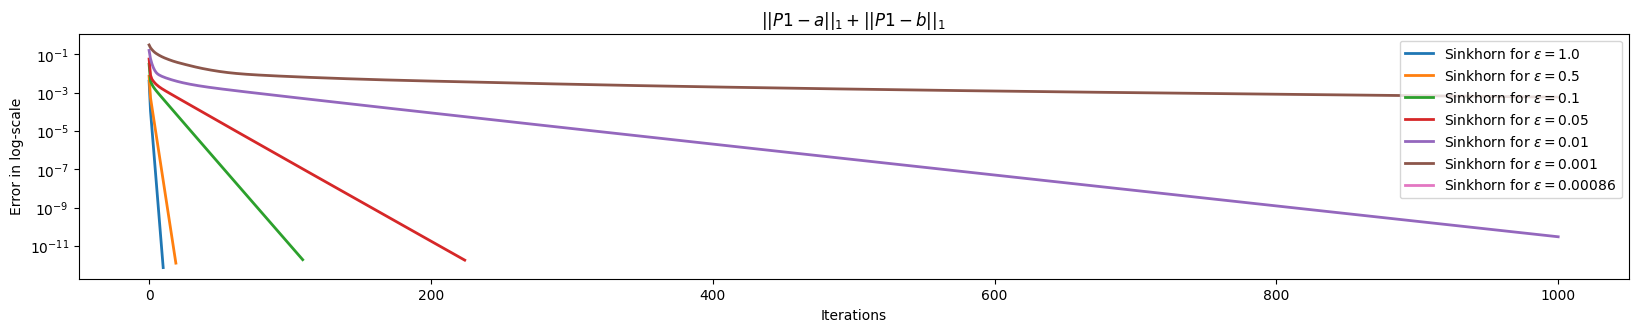

In [ ]:
plt.figure( figsize = (20,7) )

plt.subplot(2,1,1),
plt.title( "$||P1 -a||_1+||P1 -b||_1$" )
for i in range( len(results_Sinkhorn) ):
  error=np.asarray( results_Sinkhorn[i]['error_a'] )+np.asarray( results_Sinkhorn[i]['error_b'] )
  plt.plot( error,label = 'Sinkhorn for $\epsilon=$'+ str(epsilons[i]), linewidth = 2 )
plt.yscale( 'log' )
plt.legend()
plt.xlabel("Iterations")
plt.ylabel("Error in log-scale")

plt.show()


#### Spectral plot

In [ ]:
Hessians_sinkhorn = []
for i in range(len(epsilons)):
    u  = np.exp((results_Sinkhorn[i]['potential_f'])/epsilons[i])  
    v  = np.exp((results_Sinkhorn[i]['potential_g'])/epsilons[i])
    K  = np.exp(-C/epsilons[i])
    r1 = u[:,None]*np.dot(K,v)[:,None] 
    r2 = v[:,None]*np.dot(K.T,u)[:,None]                                
    P  = u[:,None]*np.exp(-C/epsilons[i])*v[None,:]
    A  = np.diag( np.array(r1.reshape(r1.shape[0],)) )
    B  = P       
    C_ = P.T
    D  = np.diag( np.array(r2.reshape(r2.shape[0],)) )
    result = np.vstack( ( np.hstack((A,B)), np.hstack((C_,D)) ) )    
    diag   = 1/np.sqrt(np.diag( result ).flatten())
    result = diag[:,None]*result*diag[None,:]
    Hessians_sinkhorn.append(result)

In [ ]:
eigs = []
eigvecs = []
for i in range(len(epsilons)):
    eps = epsilons[i]
    print("Spectral statistics of Hessian for epsilon="+str(eps))
    ev = spectral_decomposition( Hessians_sinkhorn[i] )
    eigs.append(ev[0])
    eigvecs.append(ev[1])
    print("")


Spectral statistics of Hessian for epsilon=1.0
List of smallest eigenvalues:  [-9.50628465e-16  6.48489571e-01  6.64969678e-01  9.15826321e-01
  9.43785390e-01  9.89048065e-01  9.89607240e-01  9.90276224e-01
  9.98504570e-01  9.98616669e-01]
List of largest  eigenvalues:  [1.00138333 1.00149543 1.00972378 1.01039276 1.01095194 1.05621461
 1.08417368 1.33503032 1.35151043 2.        ]

Spectral statistics of Hessian for epsilon=0.5
List of smallest eigenvalues:  [4.66206934e-17 4.23862028e-01 4.45177314e-01 7.60246766e-01
 8.26259253e-01 9.41341914e-01 9.43222244e-01 9.68995164e-01
 9.87868093e-01 9.88516659e-01]
List of largest  eigenvalues:  [1.01148334 1.01213191 1.03100484 1.05677776 1.05865809 1.17374075
 1.23975323 1.55482269 1.57613797 2.        ]

Spectral statistics of Hessian for epsilon=0.1
List of smallest eigenvalues:  [4.46360529e-16 9.25797263e-02 1.01062875e-01 2.70738661e-01
 3.23314694e-01 5.00338560e-01 5.08021851e-01 6.56911422e-01
 6.98637358e-01 7.99707848e-01]
List

ValueError: autodetected range of [nan, nan] is not finite

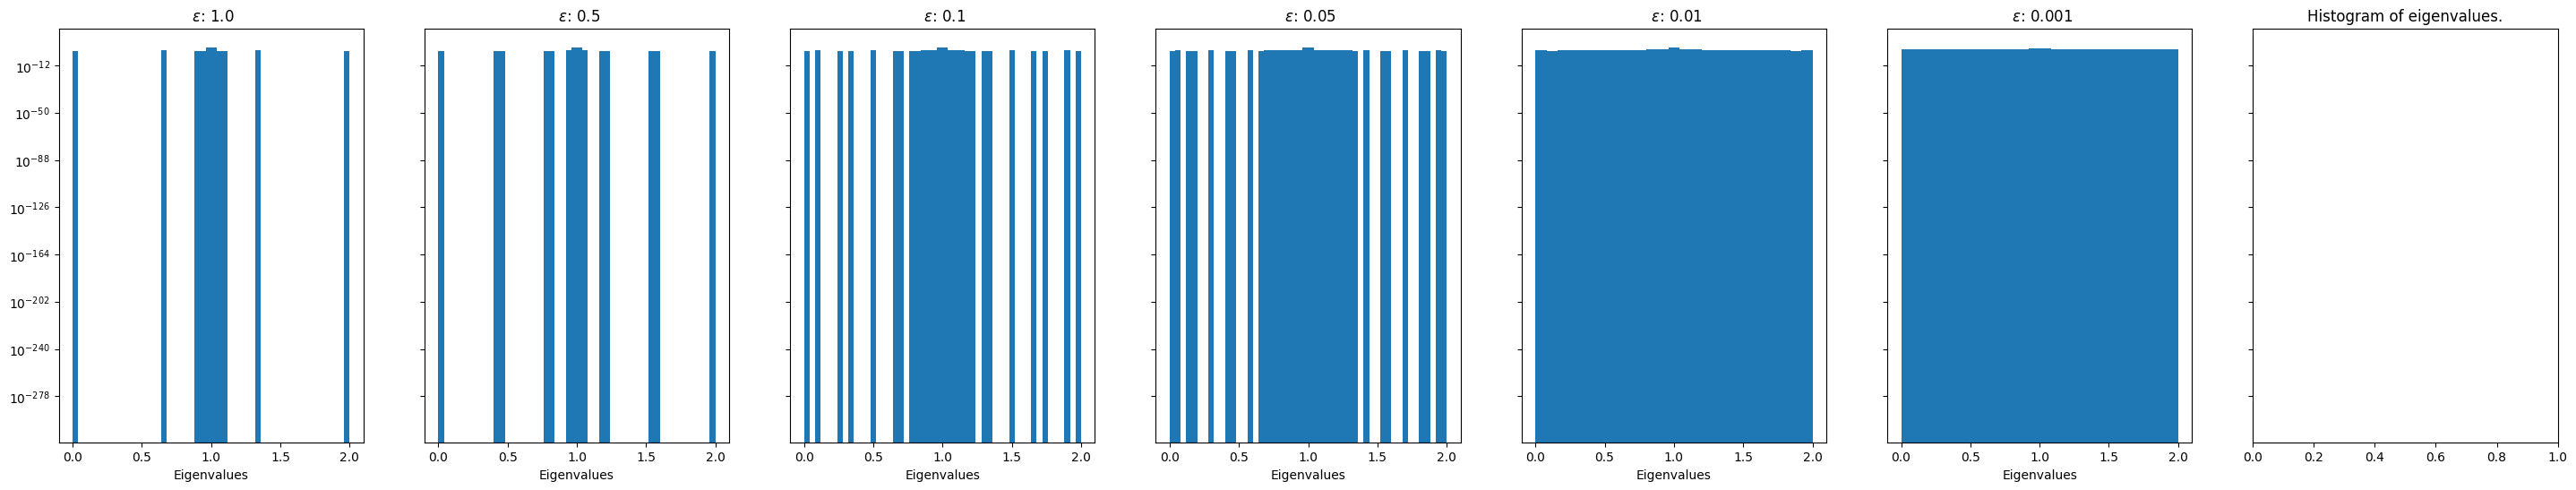

In [ ]:
fig,ax = plt.subplots(figsize = (36,6), nrows = 1, ncols = len(epsilons), sharey = True)
plt.title("Histogram of eigenvalues.")
for i in range(len(epsilons)):
    ax[i].hist( eigs[i], 50)
    ax[i].set_title( " $\epsilon$: "+str(epsilons[i]))
    ax[i].set_xlabel("Eigenvalues")
    # ax[i].set_ylim(ymin = 1e-001)
    ax[i].set_yscale( "log" )
plt.subplots_adjust(wspace=0,hspace=0)
plt.show()